### Sample program for clustering of documents with doc2vec  
- Consider Bi-gram  
- Apply preprocess_string to content strings

#### Import libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.parsing.preprocessing import preprocess_string
from gensim.models.phrases import Phrases, Phraser
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### Parameters  

In [2]:
csv_in = 'newsgroups5-2.csv'
min_count = 10
min_words = 50

embed_size = 300
model_file = 'doc2vec_newsgroups5-2.model'

#### Read CSV file  

In [3]:
df = pd.read_csv(csv_in, delimiter=',', skiprows=0, header=0)
print(df.shape)
print(df.info())
display(df.head())

(2927, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   content       2927 non-null   object
 1   target        2927 non-null   int64 
 2   target_names  2927 non-null   object
dtypes: int64(1), object(2)
memory usage: 68.7+ KB
None


,content,target,target_names
0,"From article <C5owCB.n3p@world.std.com>, by t...",1,sci.space
1,In article <1r1eu1$4t@transfer.stratus.com> c...,3,talk.politics.guns
2,In article <1993Apr23.184732.1105@aio.jsc.nas...,1,sci.space
3,What is the EXACT entry (parameter and synta...,2,comp.windows.x
4,In article <1993Apr20.151818.4319@samba.oit.u...,0,rec.sport.hockey


#### Delete too short docs  

In [4]:
df = df[ df['content'].map(lambda x: len(x.split())) >= min_words ]
df = df.reset_index(drop=True)
print(df.shape)

(2693, 3)


#### Check the number of documents in each category  

In [5]:
print(df['target'].value_counts())

4    570
1    550
0    543
3    528
2    502
Name: target, dtype: int64


#### Remove stop_words, punctuations, etc.   

In [6]:
df['content'] = df['content'].map(preprocess_string)
display(df.head())

,content,target,target_names
0,"[articl, tombak, world, std, com, tom, baker, ...",1,sci.space
1,"[articl, cdt, stratu, com, tavar, articl, dfo,...",3,talk.politics.guns
2,"[articl, kjenk, gothamc, jsc, nasa, gov, write...",1,sci.space
3,"[exact, entri, paramet, syntax, termin, config...",2,comp.windows.x
4,"[articl, scott, mark, launchpad, unc, edu, sco...",0,rec.sport.hockey


#### Detect Bi-gram  

In [7]:
words = []
for i in range(len(df)):
    #print(i, df.at[i, 'content'])
    words.append(df.at[i, 'content'])
    #print(len(words))  # debug
#print(words[:5])  # debug

In [8]:
%%time

phrases_bi = Phrases(words, min_count=30, threshold=10.0)
bigram = Phraser(phrases_bi)
df['content'] = df['content'].map(lambda x: bigram[x])
display(df.head())

,content,target,target_names
0,"[articl, tombak, world, std, com, tom, baker, ...",1,sci.space
1,"[articl, cdt_stratu, com_tavar, articl, dfo, v...",3,talk.politics.guns
2,"[articl, kjenk, gothamc, jsc, nasa_gov, write,...",1,sci.space
3,"[exact, entri, paramet, syntax, termin, config...",2,comp.windows.x
4,"[articl, scott, mark, launchpad, unc, edu_scot...",0,rec.sport.hockey


CPU times: user 3.28 s, sys: 31.6 ms, total: 3.31 s
Wall time: 3.32 s


##### Test of bigram  

In [9]:
print(bigram[ ['new', 'york'] ])

['new_york']


#### Assign docID according to its category  
- docID = 'd' + number, such as d0, d1, ..., d1000, d1001, ...
 - number = target * 1000 + j

In [10]:
docID = []
j = np.zeros(len(df['target'].value_counts()))
for i in range(len(df)):
    tgt = df.at[i, 'target']
    # base of document ID:
    #   0 for documents of target 0, 1000 for documents of target 1,
    #   2000 for documents of target 2, ...
    docID.append('d'+str(int(tgt*1000+j[tgt])))
    # increment j for target "tgt"
    j[tgt] += 1
df['docID'] = docID
display(df.head())

,content,target,target_names,docID
0,"[articl, tombak, world, std, com, tom, baker, ...",1,sci.space,d1000
1,"[articl, cdt_stratu, com_tavar, articl, dfo, v...",3,talk.politics.guns,d3000
2,"[articl, kjenk, gothamc, jsc, nasa_gov, write,...",1,sci.space,d1001
3,"[exact, entri, paramet, syntax, termin, config...",2,comp.windows.x,d2000
4,"[articl, scott, mark, launchpad, unc, edu_scot...",0,rec.sport.hockey,d0


#### Calculation of Doc2Vec  

In [11]:
docs = []
for i in range(len(df)):
    c = df.at[i, 'content']
    doc_id = df.at[i, 'docID']
    # make TaggedDocument
    td = TaggedDocument(words=c, tags=[doc_id])
    docs.append(td)

#### Calculation of doc vectors  

In [12]:
%%time

#model = Doc2Vec(documents=docs, vector_size=embed_size,
#                min_count=min_count, dm=0, epochs=20) # PV-DBOW
model = Doc2Vec(documents=docs, vector_size=embed_size,
                min_count=min_count, dm=1, epochs=20)  # PV-DM
print(model)

model.init_sims(replace=True)
model.save(model_file)
 
# If you want to read saved model
# model = Doc2Vec.load('doc2vec.model')

Doc2Vec(dm/m,d300,n5,w5,mc10,s0.001,t3)
CPU times: user 34.5 s, sys: 700 ms, total: 35.2 s
Wall time: 15.8 s


##### Check word set  

In [13]:
print(len(model.wv.vocab.keys()))  # number of words
print(list(model.wv.vocab.keys())[:10])  # show first 10 words

5079
['articl', 'world', 'std', 'com', 'tom', 'baker', 'edu', 'pack', 'rat', 'write']


In [14]:
docvecs = model.docvecs.vectors_docs
print(docvecs.shape)

(2693, 300)


#### Elbow method to determine the number of clusters  

1
2
3
4
5
6
7


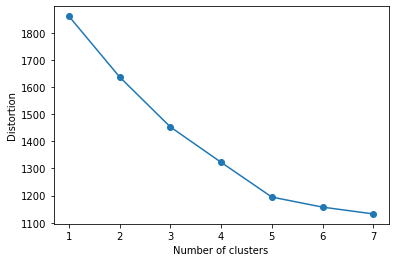

CPU times: user 24 s, sys: 20.4 s, total: 44.4 s
Wall time: 6.29 s


In [15]:
%%time

max_cls = 7
distortions = []
for i in range(1, max_cls+1):
    print(i)
    km = KMeans(n_clusters=i)
    km.fit(docvecs)
    distortions.append(km.inertia_)
plt.plot(range(1, max_cls+1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

#### K-Means clustering  

In [16]:
n_cls = 5
km = KMeans(n_clusters=n_cls, random_state=7)
cls = km.fit_predict(docvecs)

#### Check correspondence of target and clusters  

In [17]:
display(pd.crosstab(df['target'], cls))

col_0,0,1,2,3,4
target,,,,,
0,0,0,2,539,2
1,497,4,15,6,28
2,5,1,3,5,488
3,8,11,502,4,3
4,5,472,48,5,40


#### Visualization using PCA  

In [18]:
%%time

pca = PCA(n_components=2)
Y_pca = pca.fit_transform(docvecs)

CPU times: user 407 ms, sys: 332 ms, total: 739 ms
Wall time: 101 ms


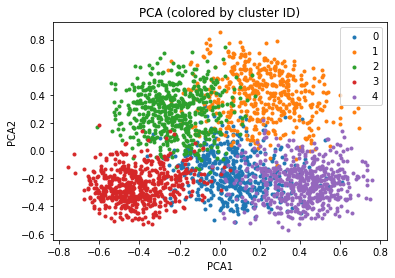

In [19]:
plt.title("PCA (colored by cluster ID)")
marker = '.'
for i in range(n_cls):
    y1 = Y_pca[ cls==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

#### Plot of PCA colored by target  

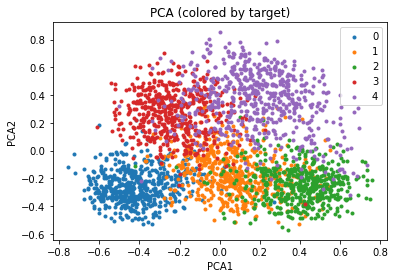

In [20]:
#plt.figure(figsize=(10,7))
plt.title("PCA (colored by target)")
marker = '.'
for i in range(n_cls):
    y1 = Y_pca[ df['target']==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

#### Visualization using t-SNE  

In [21]:
%%time

Y_tsne = TSNE(n_components=2,
              perplexity=30, n_iter=500,
              random_state=0).fit_transform(docvecs)

/home/anhvu/miniconda3/envs/ds21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/anhvu/miniconda3/envs/ds21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 34.4 s, sys: 2.02 s, total: 36.5 s
Wall time: 4.98 s


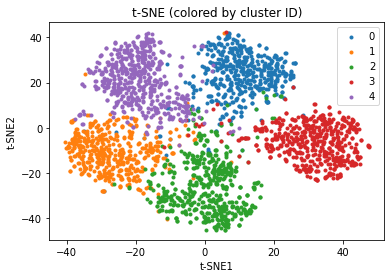

In [22]:
#plt.figure(figsize=(10,7))
plt.title("t-SNE (colored by cluster ID)")
marker = '.'
for i in range(n_cls):
    y1 = Y_tsne[ cls==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)
    
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.show()

#### Plot of t-SNE colored by target  

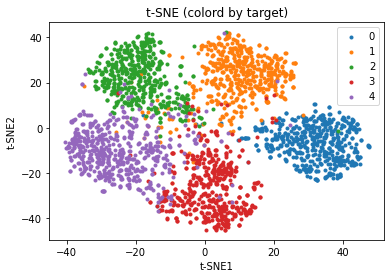

In [23]:
#plt.figure(figsize=(10,7))
plt.title("t-SNE (colord by target)")
marker = '.'
for i in range(n_cls):
    y1 = Y_tsne[ df['target']==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)
    
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.show()